#Фролов Владимир
#Задание на стажировку
Выполнено в Google Colab

GPU: NVIDIA Tesla T4

Загрузим данные с Kaggle

In [ ]:
!pip install opendatasets

In [ ]:
import opendatasets as od
od.download('https://www.kaggle.com/datasets/timoboz/clevr-dataset')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: vovafrolov
Your Kaggle Key: ··········


100%|██████████| 17.7G/17.7G [13:54<00:00, 22.8MB/s]


In [ ]:
import json
import os
import random
import numpy as np
import pandas as pd
from PIL import Image
from time import time
from tqdm.notebook import tqdm, trange

import torch
from torch import nn, optim
from torch.optim import SGD, lr_scheduler
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torchvision.transforms as transforms
from torchvision import utils as vutils
from torch.utils.data import Dataset, DataLoader

import seaborn as sns
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings(action='ignore')

In [ ]:
'''Функция для фиксации сида'''
seed = 42
def seed_torch(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) # if you are using multi-GPU.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

Напишем функцию, возвращающую пути к объектам двух выборок: обучающей и валидационной.

In [ ]:
def compact(l):
    return list(filter(None, l))

def get_paths_images(max_n_objects, dataset_type='train'):
    '''
    Функция, возвращающая список путей к изображениям в зависимости от 'dataset_type',
    который подаётся ей на вход ('train', 'val')
    '''

    labels_dict = {
        'train': 0,
        'val': 1
    }

    data_root = '/content/clevr-dataset/CLEVR_v1.0/'
    data_path = os.path.join(data_root, 'images', dataset_type)
    with open(os.path.join(data_root, f'scenes/CLEVR_{dataset_type}_scenes.json')) as f:
        scene = json.load(f)

    paths = []
    max_num_images = None
    total_num_images = len(scene['scenes'])
    i = 0
    while (max_num_images is None or len(paths) < max_num_images) and i < total_num_images:
        num_objects_in_scene = len(scene['scenes'][i]['objects'])
        if num_objects_in_scene <= max_n_objects:
            image_path = os.path.join(data_path, scene['scenes'][i]['image_filename'])
            assert os.path.exists(image_path), f'{image_path} does not exist'
            paths.append(image_path)
        i += 1

    return np.array(sorted(compact(paths)))

In [ ]:
'''
Класс, возвращающий сэмплы (в нашем случае только изображения) из той выборки,
которая будет указана в параметре 'dataset_type'
'''
class CLEVRDataset(Dataset):
    def __init__(self, dataset_type, max_n_objects, transforms=None):
        self.objects = max_n_objects
        self.images = get_paths_images(max_n_objects=self.objects, dataset_type=dataset_type)
        self.dataset_type = dataset_type
        self.transforms = transforms

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img = np.array(Image.open(img_name).convert('RGB'))

        if self.transforms is not None:
            img = self.transforms(img)

        sample = {'image': img}

        return sample

In [ ]:
transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: 2 * x - 1.0),  # rescale between -1 and 1
    transforms.Resize((64, 64))
])

В качестве датасета будем использовать CLEVR6, поэтому параметр 'max_n_objects' устанавливаем равным 6.

In [ ]:
max_n_objects = 6
train_dataset = CLEVRDataset(max_n_objects=max_n_objects, dataset_type='train', transforms=transforms)
val_dataset = CLEVRDataset(max_n_objects=max_n_objects, dataset_type='val', transforms=transforms)

batch_size = 64
seed_torch(seed)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

In [ ]:
len(train_dataloader.sampler), len(train_dataloader.sampler) % batch_size, len(train_dataset)

(35030, 22, 35030)

Обучающая выборка поделилась на 'batch_size' остатком, поэтому лосс по каждому батчу будем перевзвешивать на величину, равную количеству изображений в этом батче, а затем сумму лоссов по всем батчам отнормируем на величину общего количества изображений в соответствующей выборке (обучающей или валидационной). Это будет написано далее в функции 'train'.

Size for images  ------> torch.Size([64, 3, 64, 64])


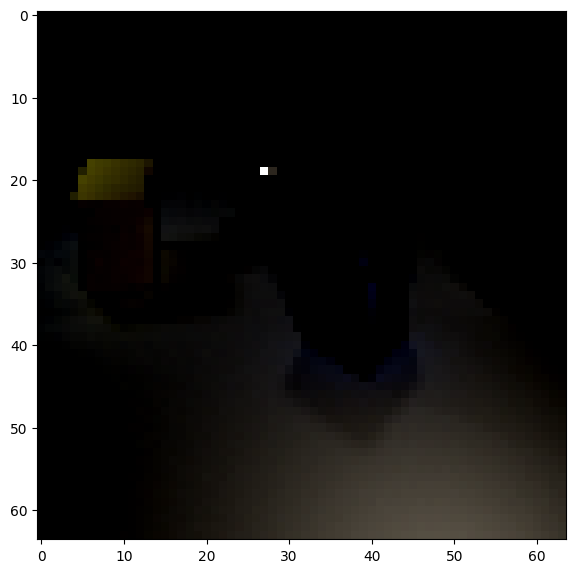

In [ ]:
for i in train_dataloader:
    plt.subplots(figsize=(15, 30))
    plt.subplot(1, 2, 1)
    plt.imshow(i['image'][0].permute(1, 2, 0))
    print('Size for images  ------>', i['image'].shape)
    break

In [ ]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(DEVICE)
torch.cuda.empty_cache()
!nvidia-smi

cuda
Sat Sep 30 22:10:33 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8    11W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+--

#Part 1
При реализации архитектуры вдохновлялся [этим репозиторием](https://github.com/untitled-ai/slot_attention).

In [ ]:
def conv_transpose_out_shape(in_size, stride, padding, kernel_size, out_padding, dilation=1):
    return (in_size - 1) * stride - 2 * padding + dilation * (kernel_size - 1) + out_padding + 1


def assert_shape(actual, expected, message=''):
    assert actual == expected, f"Expected shape: {expected} but passed shape: {actual}. {message}"

def build_grid(resolution):
    ranges = [torch.linspace(0.0, 1.0, steps=res) for res in resolution]
    grid = torch.meshgrid(*ranges)
    grid = torch.stack(grid, dim=-1)
    grid = torch.reshape(grid, [resolution[0], resolution[1], -1])
    grid = grid.unsqueeze(0)
    return torch.cat([grid, 1.0 - grid], dim=-1)

In [ ]:
class SlotAttention(nn.Module):
    def __init__(self, in_features, num_iterations, num_slots, slot_size, mlp_hidden_size, epsilon=1e-8, train_mode="original"):
        super().__init__()
        self.in_features = in_features
        self.num_iterations = num_iterations
        self.num_slots = num_slots
        self.slot_size = slot_size  # number of hidden layers in slot dimensions
        self.mlp_hidden_size = mlp_hidden_size
        self.epsilon = epsilon

        self.norm_inputs = nn.LayerNorm(self.in_features)
        # I guess this is layer norm across each slot? should look into this
        self.norm_slots = nn.LayerNorm(self.slot_size)
        self.norm_mlp = nn.LayerNorm(self.slot_size)

        # Linear maps for the attention module.
        self.project_q = nn.Linear(self.slot_size, self.slot_size, bias=False)
        self.project_k = nn.Linear(self.slot_size, self.slot_size, bias=False)
        self.project_v = nn.Linear(self.slot_size, self.slot_size, bias=False)

        # Slot update functions.
        self.gru = nn.GRUCell(self.slot_size, self.slot_size)
        self.mlp = nn.Sequential(
            nn.Linear(self.slot_size, self.mlp_hidden_size),
            nn.ReLU(),
            nn.Linear(self.mlp_hidden_size, self.slot_size),
        )
        self.train_mode = train_mode
        if train_mode == "original":
            self.register_buffer(
                "slots_mu",
                nn.init.xavier_uniform_(torch.zeros((1, 1, self.slot_size)), gain=nn.init.calculate_gain("linear")),
                )
            self.register_buffer(
                "slots_log_sigma",
                nn.init.xavier_uniform_(torch.zeros((1, 1, self.slot_size)), gain=nn.init.calculate_gain("linear")),
                )
        elif train_mode == "module":
            print("Using modular distribution parameter training mode.")
        else:
            raise ValueError("Unknown distribution parameter training mode!")

    def step(self, slots, k, v, num_inputs, batch_size):
        slots_prev = slots
        slots = self.norm_slots(slots)

        # Attention.
        q = self.project_q(slots)  # Shape: [batch_size, num_slots, slot_size].
        assert_shape(q.size(), (batch_size, self.num_slots, self.slot_size))

        attn_norm_factor = self.slot_size**-0.5
        attn_logits = attn_norm_factor * torch.matmul(k, q.transpose(2, 1))
        attn = F.softmax(attn_logits, dim=-1)
        # `attn` has shape: [batch_size, num_inputs, num_slots].
        assert_shape(attn.size(), (batch_size, num_inputs, self.num_slots))

        # Weighted mean.
        attn = attn + self.epsilon
        attn = attn / torch.sum(attn, dim=1, keepdim=True)
        updates = torch.matmul(attn.transpose(1, 2), v)
        # `updates` has shape: [batch_size, num_slots, slot_size].
        assert_shape(updates.size(), (batch_size, self.num_slots, self.slot_size))

        # Slot update.
        # GRU is expecting inputs of size (N,H) so flatten batch and slots dimension
        slots = self.gru(
            updates.view(batch_size * self.num_slots, self.slot_size),
            slots_prev.view(batch_size * self.num_slots, self.slot_size),
        )
        slots = slots.view(batch_size, self.num_slots, self.slot_size)
        assert_shape(slots.size(), (batch_size, self.num_slots, self.slot_size))
        slots = slots + self.mlp(self.norm_mlp(slots))
        assert_shape(slots.size(), (batch_size, self.num_slots, self.slot_size))

        return slots

    def forward(self, inputs, slots_mu=None, slots_log_sigma=None):
        # `inputs` has shape [batch_size, num_inputs, inputs_size].
        batch_size, num_inputs, inputs_size = inputs.shape
        inputs = self.norm_inputs(inputs)  # Apply layer norm to the input.
        k = self.project_k(inputs)  # Shape: [batch_size, num_inputs, slot_size].
        assert_shape(k.size(), (batch_size, num_inputs, self.slot_size))
        v = self.project_v(inputs)  # Shape: [batch_size, num_inputs, slot_size].
        assert_shape(v.size(), (batch_size, num_inputs, self.slot_size))

        # Initialize the slots. Shape: [batch_size, num_slots, slot_size].
        slots_init = torch.randn((batch_size, self.num_slots, self.slot_size))
        slots_init = slots_init.type_as(inputs)
        if self.train_mode == "module":
            self.slots_mu = slots_mu
            self.slots_log_sigma = slots_log_sigma
        slots = self.slots_mu + self.slots_log_sigma.exp() * slots_init

        # Multiple rounds of attention.
        for _ in range(self.num_iterations):
            if self.train_mode == "module":
                slots = self.norm_slots(slots)
            slots = self.step(slots, k, v, num_inputs, batch_size)
        # Трюк из статьи "OBJECT REPRESENTATIONS AS FIXED POINTS: TRAINING
        # ITERATIVE INFERENCE ALGORITHMS WITH IMPLICIT DIFFERENTIATION" (2022)
        slots = self.step(slots.detach(), k, v, num_inputs, batch_size)

        return slots

In [ ]:
class SlotAttentionModel(nn.Module):
    def __init__(
        self, resolution, num_slots, num_iterations, in_channels=3,
        kernel_size=5, slot_size=64, hidden_dims=(64, 64, 64, 64),
        decoder_resolution=(8, 8), empty_cache=False, train_mode="original"
        ):
        super().__init__()
        self.resolution = resolution
        self.num_slots = num_slots
        self.num_iterations = num_iterations
        self.in_channels = in_channels
        self.kernel_size = kernel_size
        self.slot_size = slot_size
        self.empty_cache = empty_cache
        self.hidden_dims = hidden_dims
        self.decoder_resolution = decoder_resolution
        self.out_features = self.hidden_dims[-1]
        self.train_mode = train_mode
        modules = []
        channels = self.in_channels
        # Build Encoder
        for h_dim in self.hidden_dims:
            modules.append(nn.Sequential(
                nn.Conv2d(
                    channels, out_channels=h_dim, kernel_size=self.kernel_size,
                    stride=1, padding=self.kernel_size//2,
                    ),
                nn.LeakyReLU()
                )
            )
            channels = h_dim

        self.encoder = nn.Sequential(*modules)
        self.encoder_pos_embedding = SoftPositionEmbed(self.in_channels, self.out_features, resolution)
        self.encoder_out_layer = nn.Sequential(
            nn.Linear(self.out_features, self.out_features),
            nn.LeakyReLU(),
            nn.Linear(self.out_features, self.out_features),
        )

        # Модули для части 2
        self.slots_mu = nn.Sequential(
            nn.Linear(self.out_features, 32),
            nn.LeakyReLU(),
            nn.Linear(32, 2),
            nn.LeakyReLU(),
            nn.Flatten(),
            nn.Linear(self.resolution[0]*self.resolution[1] * 2, self.slot_size)

        )
        self.slots_log_sigma = nn.Sequential(
            nn.Linear(self.out_features, 32),
            nn.LeakyReLU(),
            nn.Linear(32, 2),
            nn.LeakyReLU(),
            nn.Flatten(),
            nn.Linear(self.resolution[0]*self.resolution[1] * 2, self.slot_size)

        )

        # Build Decoder
        modules = []

        in_size = decoder_resolution[0]
        out_size = in_size

        for i in range(len(self.hidden_dims) -1, -1, -1):
            modules.append(nn.Sequential(
                nn.ConvTranspose2d(
                    self.hidden_dims[i], self.hidden_dims[i-1], kernel_size=5,
                    stride=2, padding=2, output_padding=1
                    ),
                nn.LeakyReLU()
                )
            )
            out_size = conv_transpose_out_shape(out_size, 2, 2, 5, 1)

        assert_shape(resolution, (out_size, out_size),
                     message="Output shape of decoder did not match input resolution. Try changing `decoder_resolution`."
                     )

        # same convolutions
        modules.append(nn.Sequential(
            nn.ConvTranspose2d(
                self.out_features, self.out_features, kernel_size=5, stride=1,
                padding=2, output_padding=0
                ),
                nn.LeakyReLU(),
                nn.ConvTranspose2d(self.out_features, 4, kernel_size=3, stride=1, padding=1, output_padding=0)
            )
        )

        assert_shape(resolution, (out_size, out_size), message='')

        self.decoder = nn.Sequential(*modules)
        self.decoder_pos_embedding = SoftPositionEmbed(self.in_channels, self.out_features, self.decoder_resolution)

        self.slot_attention = SlotAttention(
            in_features=self.out_features,
            num_iterations=self.num_iterations,
            num_slots=self.num_slots,
            slot_size=self.slot_size,
            mlp_hidden_size=128,
            train_mode=self.train_mode
        )

    def forward(self, x):
        if self.empty_cache:
            torch.cuda.empty_cache()

        batch_size, num_channels, height, width = x.shape
        encoder_out = self.encoder(x)
        encoder_out = self.encoder_pos_embedding(encoder_out)
        # `encoder_out` has shape: [batch_size, filter_size, height, width]
        encoder_out = torch.flatten(encoder_out, start_dim=2, end_dim=3)
        # `encoder_out` has shape: [batch_size, filter_size, height*width]
        encoder_out = encoder_out.permute(0, 2, 1)
        encoder_out = self.encoder_out_layer(encoder_out)
        # `encoder_out` has shape: [batch_size, height*width, filter_size]

        slots_mu, slots_log_sigma = None, None
        if self.train_mode=="module":
            slots_mu, slots_log_sigma = self.slots_mu(encoder_out), self.slots_log_sigma(encoder_out)
            slots_mu, slots_log_sigma = slots_mu.sum(axis=0), slots_log_sigma.sum(axis=0)
            slots_mu, slots_log_sigma = slots_mu.reshape((1, 1, self.slot_size)), slots_log_sigma.reshape((1, 1, self.slot_size))
        slots = self.slot_attention(encoder_out, slots_mu, slots_log_sigma)
        assert_shape(slots.size(), (batch_size, self.num_slots, self.slot_size))
        # `slots` has shape: [batch_size, num_slots, slot_size].
        batch_size, num_slots, slot_size = slots.shape

        slots = slots.view(batch_size * num_slots, slot_size, 1, 1)
        decoder_in = slots.repeat(1, 1, self.decoder_resolution[0], self.decoder_resolution[1])

        out = self.decoder_pos_embedding(decoder_in)
        out = self.decoder(out)
        # `out` has shape: [batch_size*num_slots, num_channels+1, height, width].
        assert_shape(out.size(), (batch_size * num_slots, num_channels + 1, height, width))

        out = out.view(batch_size, num_slots, num_channels+1, height, width)
        recons = out[:, :, :num_channels, :, :]
        masks = out[:, :, -1:, :, :]
        masks = F.softmax(masks, dim=1)
        recon_combined = torch.sum(recons * masks, dim=1)
        return recon_combined, recons, masks, slots

In [ ]:
class SoftPositionEmbed(nn.Module):
    def __init__(self, num_channels, hidden_size, resolution):
        super().__init__()
        self.dense = nn.Linear(in_features=num_channels + 1, out_features=hidden_size)
        self.register_buffer("grid", build_grid(resolution))

    def forward(self, inputs):
        emb_proj = self.dense(self.grid).permute(0, 3, 1, 2)
        assert_shape(inputs.shape[1:], emb_proj.shape[1:], message='')
        return inputs + emb_proj

In [ ]:
seed_torch(seed)
model = SlotAttentionModel(resolution=(64, 64), num_slots=7, num_iterations=3, decoder_resolution=(4, 4), train_mode='original').to(DEVICE)
torch.cuda.empty_cache()
from torchsummary import summary
summary(model, (3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           4,864
         LeakyReLU-2           [-1, 64, 64, 64]               0
            Conv2d-3           [-1, 64, 64, 64]         102,464
         LeakyReLU-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]         102,464
         LeakyReLU-6           [-1, 64, 64, 64]               0
            Conv2d-7           [-1, 64, 64, 64]         102,464
         LeakyReLU-8           [-1, 64, 64, 64]               0
            Linear-9           [-1, 64, 64, 64]             320
SoftPositionEmbed-10           [-1, 64, 64, 64]               0
           Linear-11             [-1, 4096, 64]           4,160
        LeakyReLU-12             [-1, 4096, 64]               0
           Linear-13             [-1, 4096, 64]           4,160
        LayerNorm-14             [-1, 4

In [ ]:
# Params
lr = 4e-4
betas = (0.9, 0.999)
eps = 1e-8
size = (64, 64)
decoder_resolution = (4, 4)
num_slots = 7
num_iterations = 3
max_epochs = 100
scheduler_gamma = 0.5
warmup_steps_pct = 0.02
decay_steps_pct = 0.2

In [ ]:
def to_rgb_from_tensor(x):
    return (x * 0.5 + 0.5).clamp(0, 1)

Функция для LambdaLR шедулера, которая сначала линейно увеличивает LR, чтобы не застрять в неоптимальном решении на старте, а затем реализует экспоненциальное затухание LR, которое, как указано в [статье](https://arxiv.org/pdf/2006.15055.pdf), уменьшает дисперсию.

In [ ]:
seed_torch(seed)
criterion = F.mse_loss
optimizer = optim.Adam(model.parameters(), lr=lr, eps=eps, betas=betas)

def warm_and_decay_lr_scheduler(step):
    '''
    Функция для шедулера, которая сначала линейно увеличивает LR, а затем реализует
    экспоненциальное затухание LR
    '''
    warmup_steps_pct = 0.02
    decay_steps_pct = 0.2
    max_epochs = 100
    total_steps = max_epochs * len(train_dataloader)
    warmup_steps = warmup_steps_pct * total_steps
    decay_steps = decay_steps_pct * total_steps

    assert step < total_steps

    if step < warmup_steps:
        factor = step / warmup_steps
    else:
        factor = 1

    factor *= scheduler_gamma**(step / decay_steps)

    return factor

scheduler = optim.lr_scheduler.LambdaLR(optimizer=optimizer, lr_lambda=warm_and_decay_lr_scheduler)

Веса лучших моделей будем сохранять на гугл диск.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
PART1_BM_WEIGHTS = '/content/gdrive/MyDrive/Seg_Penobscot/Part1_best_model_weights'
os.makedirs(PART1_BM_WEIGHTS, exist_ok=True)

Реализуем функцию, возвращающую 5 случайных изображений из первого батча поданной на вход выборки и выходы модели для этих изображений. Т.е. по колонкам слева-направо будут изображены: исходное изображение, восстановленное моделью изображение, а остальные изображения будут взяты с выходов SlotAttention (в нашем случае 7 штук).

In [ ]:
def show_some_samples(model, loader):
    n_samples = 5
    for batch in loader:
        fig, ax = plt.subplots(1, 1, figsize=(18, 18))
        X_val = batch['image'].to(DEVICE)
        batch_size = X_val.size(0)
        perm = torch.randperm(batch_size)
        idx = perm[:n_samples]
        X_val = X_val[idx]
        recon_combined, recons, masks, slots = model(X_val)
        out = to_rgb_from_tensor(torch.cat([
            X_val.unsqueeze(1),   # original images
            recon_combined.unsqueeze(1),   # reconstructions
            recons * masks + (1 - masks)   # each slot
            ], dim=1))
        batch_size, num_slots, C, H, W = recons.shape
        images = vutils.make_grid(out.view(batch_size * out.shape[1], C, H, W).cpu(), normalize=False, nrow=out.shape[1])

        plt.imshow(np.transpose(np.array(images.cpu()), (1, 2, 0)))
        plt.title('Images')
        plt.axis('off')

        break

Реализуем функцию обучения, которая будет возвращать список лоссов по обучающей и валидационной выборкам, список значений LR для каждого шага его обновления (оптимизацию и обновление LR производили побатчево) и время обучения. Данная функция также визуализирует процесс обучения в виде бара и поясняющего текста. В конце обучения визуализируются:
- 5 случайных изображений из валидационной выборки и выходы модели для них;
- графики изменения лосса на обучаеющей и валидационной выборках;
- график изменения LR в зависимости от шага его обновления.

In [ ]:
def train(model, train_loader, val_loader, epochs, optimizer, scheduler, weights):
    since = time()

    train_losses = []
    val_losses = []
    lr_list = []
    best_loss = float('inf')

    pbar = trange(epochs, desc='Epoch:')
    for epoch in pbar:
        print('---------- Epoch %d/%d ----------' % (epoch+1, epochs))
        # Train
        tr_loss = 0
        model.train()
        for batch in tqdm(train_loader):
            X_batch = batch['image'].to(DEVICE)
            # Forward
            recon_combined, recons, masks, slots = model(X_batch)
            loss = criterion(recon_combined.to(DEVICE), X_batch)
            # Backward
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            lr_list.append(optimizer.state_dict()['param_groups'][0]['lr'])
            scheduler.step()

            tr_loss += loss.item() * X_batch.size(0)

        train_loss = tr_loss / len(train_loader.sampler)
        train_losses.append(train_loss)
        print('Train loss =', train_loss)

        # Validation
        model.eval()
        v_loss = 0
        with torch.no_grad():
            for batch in tqdm(val_loader):
                X_val = batch['image'].to(DEVICE)
                recon_combined, recons, masks, slots = model(X_val)
                loss = criterion(recon_combined.to(DEVICE), X_val)

                v_loss += loss.item() * X_val.size(0)

        val_loss = v_loss / len(val_loader.sampler)
        val_losses.append(val_loss)
        print('Val loss =', val_loss)

        if val_loss < best_loss:
            best_loss = val_loss
            torch.save(model.state_dict(), os.path.join(weights, 'Best_model_' + str(epoch+1) + '.pth'))
            print('Save best model!')

        print(f'Time: {(time() - since)}')
        # if (epoch + 1) % 5 == 0 and (epoch + 1) != epochs:
            # clear_output(wait=True)

    show_some_samples(model, val_loader)

    plt.subplots(figsize=(23, 9))
    plt.subplot(1, 2, 1)
    plt.plot(np.arange(1, len(train_losses) + 1), train_losses, label='train loss', color='orange')
    plt.plot(np.arange(1, len(val_losses) + 1), val_losses, label='val loss', color='blue')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    best_ep = np.argmin(val_losses) + 1
    plt.axvline(best_ep, color='r', label="best epoch", linestyle='--')
    plt.legend(loc='upper right')
    plt.title('Losses')

    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs * len(train_dataloader) + 1), lr_list, color='green')
    plt.xlabel('Step')
    plt.ylabel('LR')
    plt.title('Learning rate schedule')

    plt.show()

    t = time() - since

    return train_losses, val_losses, lr_list, t

Проверка функции 'show_some_samples'.

  0%|          | 0/548 [00:00<?, ?it/s]

Train loss = 0.022581106497284825
Time: 381.27121114730835


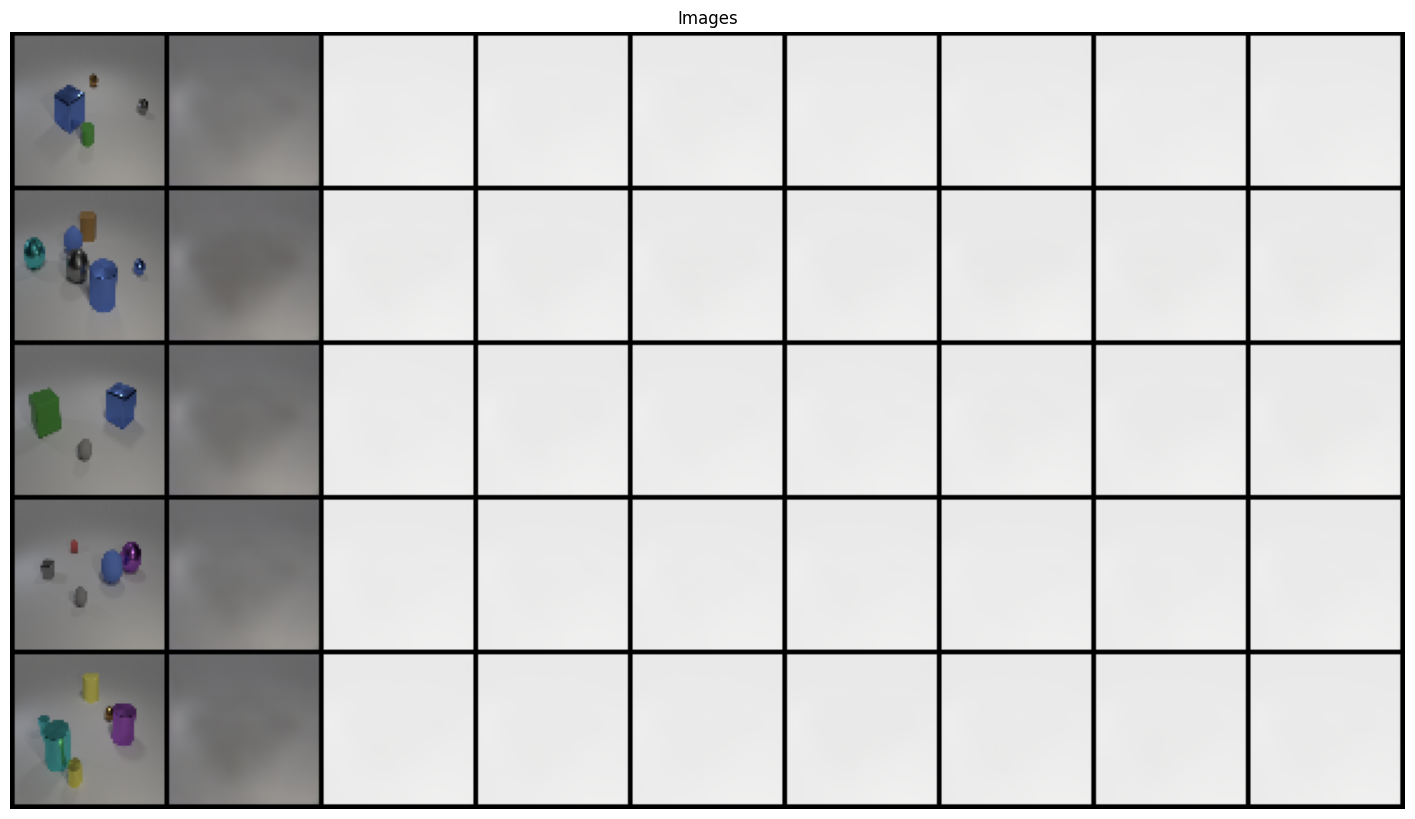

In [ ]:
seed_torch(seed)
epochs = 1
times = []
lr_list1 = []
since = time()
tr_loss = 0
model.train()
for batch in tqdm(train_dataloader):
    X_batch = batch['image'].to(DEVICE)
    # Forward
    recon_combined, recons, masks, slots = model(X_batch)
    loss = criterion(input=recon_combined.to(DEVICE), target=X_batch)
    # Backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    lr_list1.append(optimizer.state_dict()['param_groups'][0]['lr'])
    scheduler.step()

    tr_loss += loss.item() * X_batch.size(0)

train_loss = tr_loss / len(train_dataloader.sampler)
print('Train loss =', train_loss)

show_some_samples(model, val_dataloader)

t1 = time() - since
print(f'Time: {(t1)}')

Непосредственно обучение модели.

Epoch::   0%|          | 0/10 [00:00<?, ?it/s]

---------- Epoch 1/10 ----------


  0%|          | 0/548 [00:00<?, ?it/s]

Train loss = 0.01789423253194727


  0%|          | 0/118 [00:00<?, ?it/s]

Val loss = 0.016782120214074048
Save best model!
Time: 448.76986622810364
---------- Epoch 2/10 ----------


  0%|          | 0/548 [00:00<?, ?it/s]

Train loss = 0.014611957100829652


  0%|          | 0/118 [00:00<?, ?it/s]

Val loss = 0.010887063695075713
Save best model!
Time: 894.6102230548859
---------- Epoch 3/10 ----------


  0%|          | 0/548 [00:00<?, ?it/s]

Train loss = 0.009190595493277855


  0%|          | 0/118 [00:00<?, ?it/s]

Val loss = 0.008554188475155489
Save best model!
Time: 1346.6901631355286
---------- Epoch 4/10 ----------


  0%|          | 0/548 [00:00<?, ?it/s]

Train loss = 0.007487732506017625


  0%|          | 0/118 [00:00<?, ?it/s]

Val loss = 0.006799709666535223
Save best model!
Time: 1795.8381125926971
---------- Epoch 5/10 ----------


  0%|          | 0/548 [00:00<?, ?it/s]

Train loss = 0.006455166188826135


  0%|          | 0/118 [00:00<?, ?it/s]

Val loss = 0.005946933905796965
Save best model!
Time: 2252.406277656555
---------- Epoch 6/10 ----------


  0%|          | 0/548 [00:00<?, ?it/s]

Train loss = 0.005648882392407859


  0%|          | 0/118 [00:00<?, ?it/s]

Val loss = 0.005285777068090157
Save best model!
Time: 2708.0450813770294
---------- Epoch 7/10 ----------


  0%|          | 0/548 [00:00<?, ?it/s]

Train loss = 0.0051655305836369935


  0%|          | 0/118 [00:00<?, ?it/s]

Val loss = 0.004900311075381877
Save best model!
Time: 3158.9329011440277
---------- Epoch 8/10 ----------


  0%|          | 0/548 [00:00<?, ?it/s]

Train loss = 0.0047789097208473345


  0%|          | 0/118 [00:00<?, ?it/s]

Val loss = 0.0046749027480846245
Save best model!
Time: 3617.029969930649
---------- Epoch 9/10 ----------


  0%|          | 0/548 [00:00<?, ?it/s]

Train loss = 0.004509512774721788


  0%|          | 0/118 [00:00<?, ?it/s]

Val loss = 0.004297612209926501
Save best model!
Time: 4069.964441537857
---------- Epoch 10/10 ----------


  0%|          | 0/548 [00:00<?, ?it/s]

Train loss = 0.004272836224340028


  0%|          | 0/118 [00:00<?, ?it/s]

Val loss = 0.004123858077564069
Save best model!
Time: 4523.573377609253


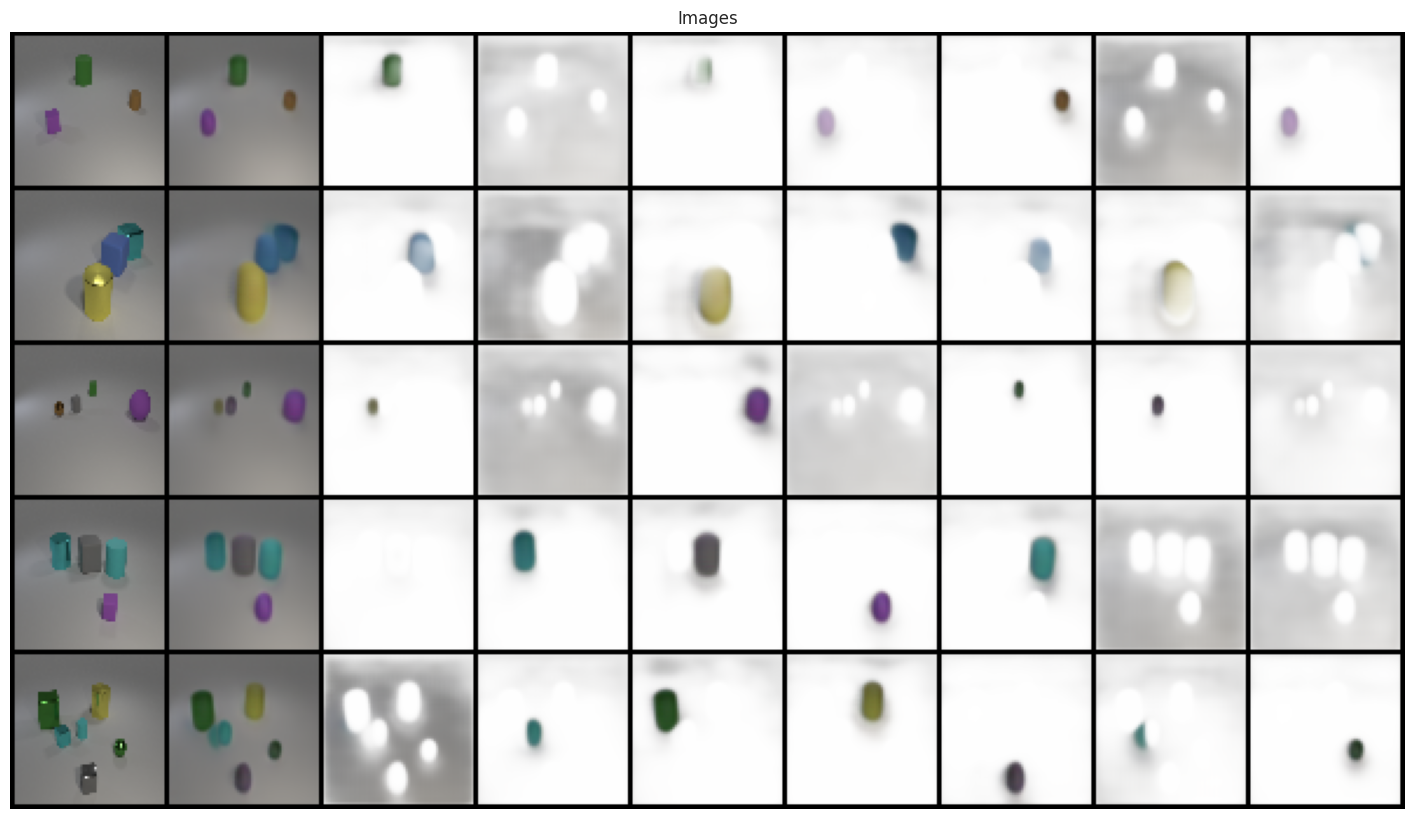

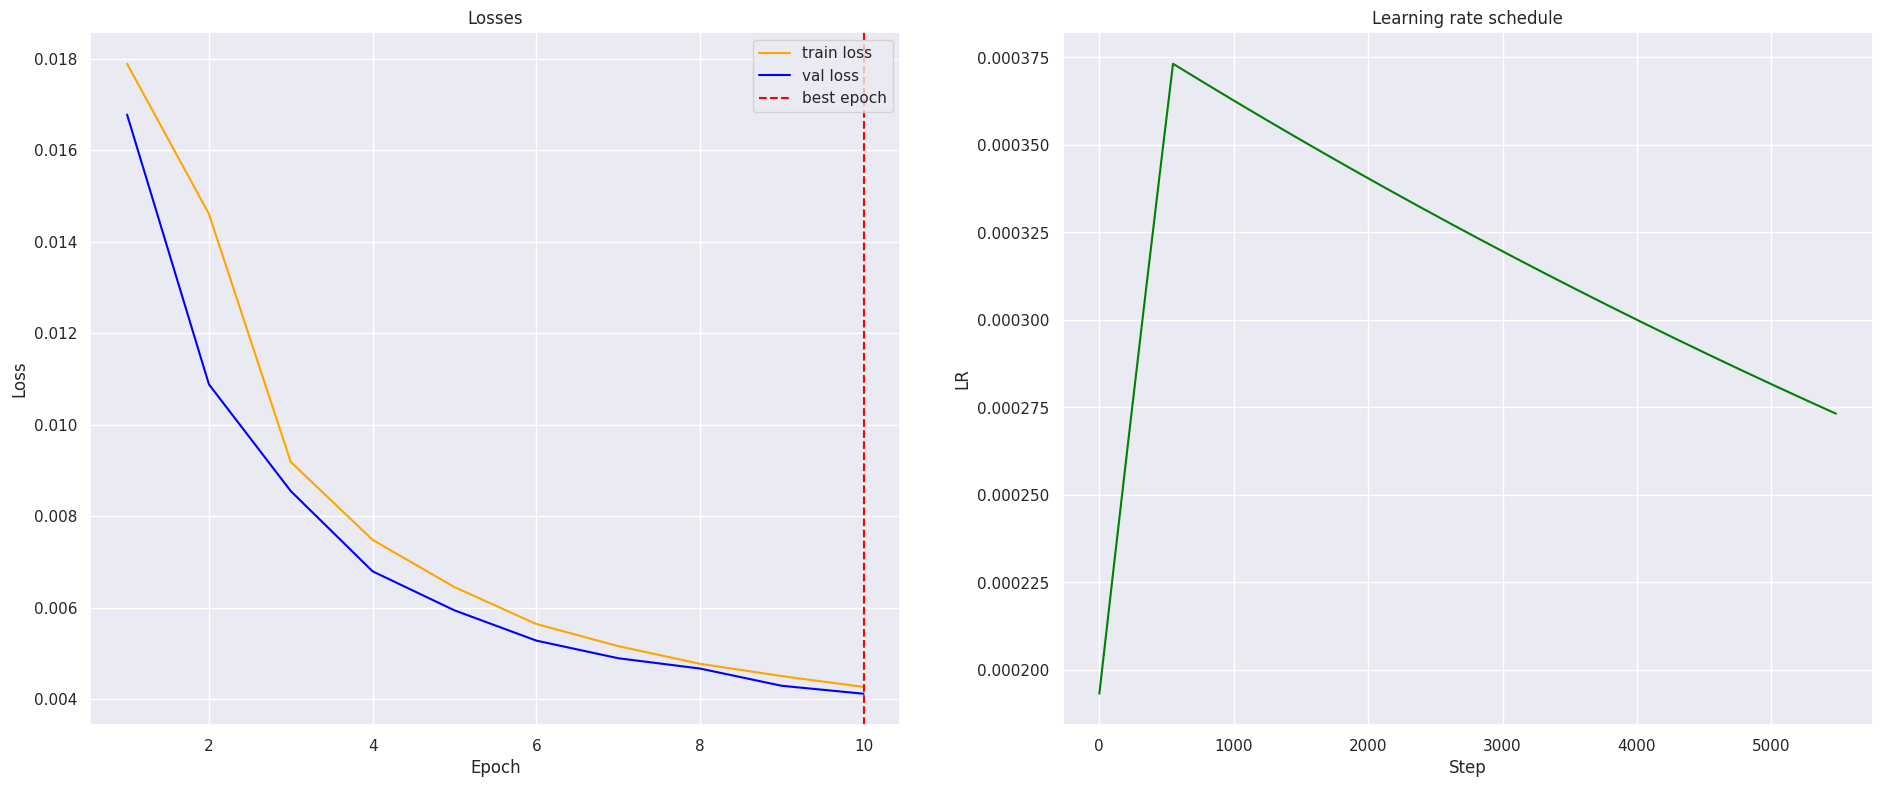

In [ ]:
seed_torch(seed)
sns.set(palette='summer')
epochs = 10
part1_tlosses, part1_vlosses, part1_lr_list, part1_time = train(model, train_dataloader,
                                                 val_dataloader, epochs, optimizer,
                                                 scheduler, PART1_BM_WEIGHTS)
t1 = t1 + part1_time
times.append(t1)

In [ ]:
t1

4909.729380607605

In [ ]:
for i in range(len(part1_lr_list)):
    lr_list1.append(part1_lr_list[i])

if len(lr_list1) == len(part1_lr_list) + len(train_dataloader):
    print(len(lr_list1) == len(part1_lr_list) + len(train_dataloader))
    del part1_lr_list

len(lr_list1)

True


6028

Полный график (с учётом одной эпохи перед непосредственно добучением модели) изменения LR в зависимости от шага его обновления.

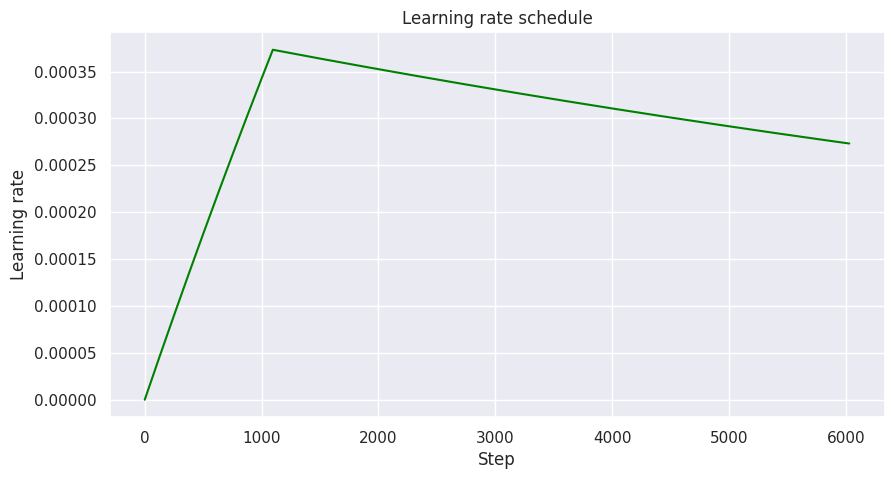

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs * len(train_dataloader) + len(train_dataloader) + 1), lr_list1, color = 'green')
plt.xlabel('Step')
plt.ylabel('Learning rate')
plt.title('Learning rate schedule')
plt.show()

#Part 2
Модуль для этой части, использующий обучающие параметры μ и σ для инициализации слотов, был реализован в архитектуре ранее и вызывается при передаче в 'train_mode' значения 'module'. Далее проделаем всё то же самое по аналогии с первой частью.

In [ ]:
seed_torch(seed)
model2 = SlotAttentionModel(resolution=(64, 64), num_slots=7, num_iterations=3, decoder_resolution=(4, 4), train_mode='module').to(DEVICE)
torch.cuda.empty_cache()
from torchsummary import summary
summary(model2, (3, 64, 64))

Using modular distribution parameter training mode.
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           4,864
         LeakyReLU-2           [-1, 64, 64, 64]               0
            Conv2d-3           [-1, 64, 64, 64]         102,464
         LeakyReLU-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]         102,464
         LeakyReLU-6           [-1, 64, 64, 64]               0
            Conv2d-7           [-1, 64, 64, 64]         102,464
         LeakyReLU-8           [-1, 64, 64, 64]               0
            Linear-9           [-1, 64, 64, 64]             320
SoftPositionEmbed-10           [-1, 64, 64, 64]               0
           Linear-11             [-1, 4096, 64]           4,160
        LeakyReLU-12             [-1, 4096, 64]               0
           Linear-13             [-1, 4096, 64]    

In [ ]:
PART2_BM_WEIGHTS = '/content/gdrive/MyDrive/Seg_Penobscot/Part2_best_model_weights'
os.makedirs(PART2_BM_WEIGHTS, exist_ok=True)

In [ ]:
seed_torch(seed)
criterion = F.mse_loss
optimizer = optim.Adam(model2.parameters(), lr=lr, eps=eps, betas=betas)
scheduler = optim.lr_scheduler.LambdaLR(optimizer=optimizer, lr_lambda=warm_and_decay_lr_scheduler)

  0%|          | 0/548 [00:00<?, ?it/s]

Train loss = 0.022580306570473958
Time: 401.6122336387634


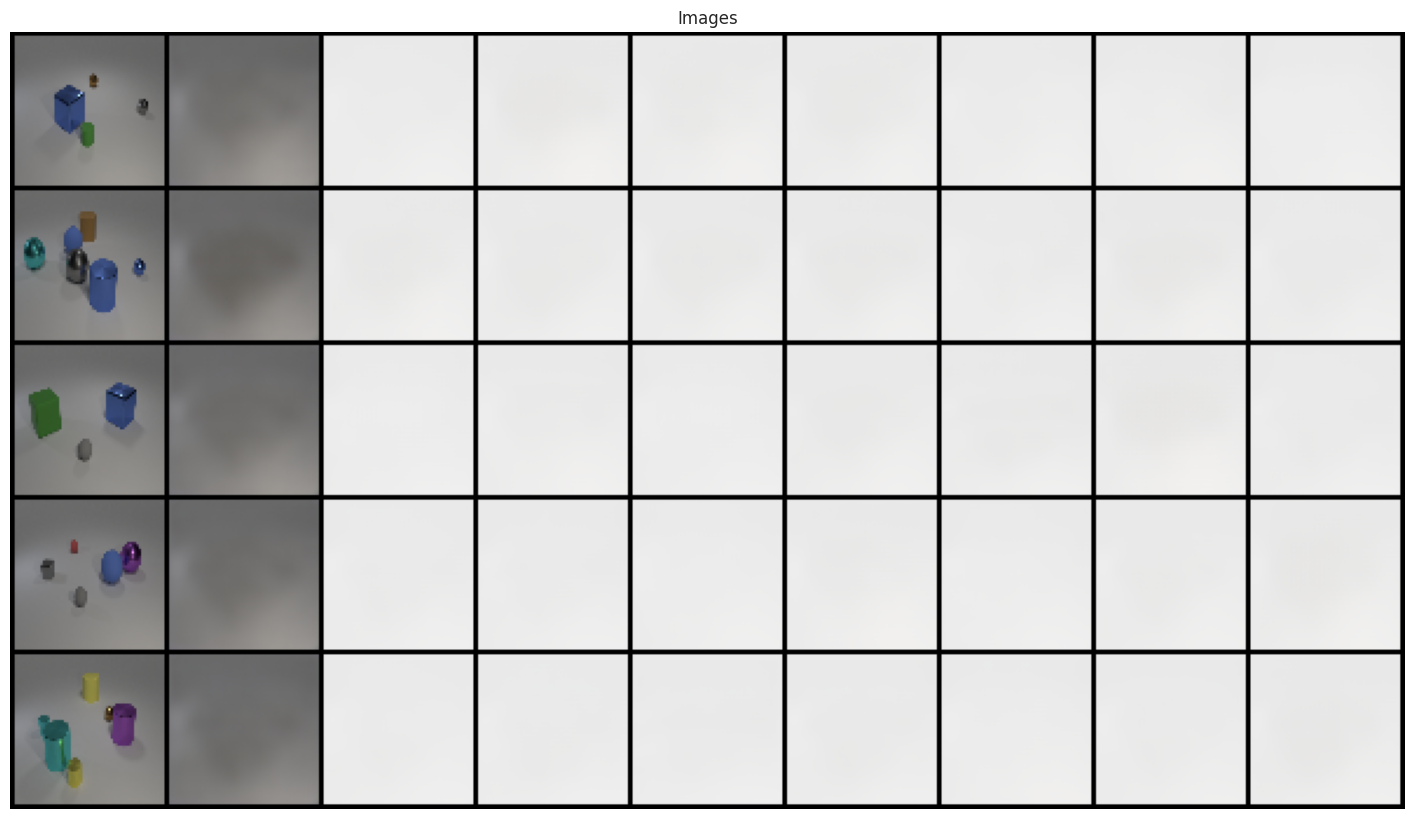

In [ ]:
seed_torch(seed)
epochs = 1
lr_list2 = []
since = time()
tr_loss = 0
model.train()
for batch in tqdm(train_dataloader):
    X_batch = batch['image'].to(DEVICE)
    # Forward
    recon_combined, recons, masks, slots = model2(X_batch)
    loss = criterion(input=recon_combined.to(DEVICE), target=X_batch)
    # Backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    lr_list2.append(optimizer.state_dict()['param_groups'][0]['lr'])
    scheduler.step()

    tr_loss += loss.item() * X_batch.size(0)

train_loss = tr_loss / len(train_dataloader.sampler)
print('Train loss =', train_loss)

show_some_samples(model2, val_dataloader)

t2 = time() - since
print(f'Time: {(t2)}')

In [ ]:
times

[4909.729380607605]

Epoch::   0%|          | 0/10 [00:00<?, ?it/s]

---------- Epoch 1/10 ----------


  0%|          | 0/548 [00:00<?, ?it/s]

Train loss = 0.017487093993116203


  0%|          | 0/118 [00:00<?, ?it/s]

Val loss = 0.016643261939314934
Save best model!
Time: 454.595988035202
---------- Epoch 2/10 ----------


  0%|          | 0/548 [00:00<?, ?it/s]

Train loss = 0.014278105378221127


  0%|          | 0/118 [00:00<?, ?it/s]

Val loss = 0.013921122229949182
Save best model!
Time: 911.9571063518524
---------- Epoch 3/10 ----------


  0%|          | 0/548 [00:00<?, ?it/s]

Train loss = 0.011497726564194828


  0%|          | 0/118 [00:00<?, ?it/s]

Val loss = 0.0099638501089537
Save best model!
Time: 1365.6728031635284
---------- Epoch 4/10 ----------


  0%|          | 0/548 [00:00<?, ?it/s]

Train loss = 0.008401537028652045


  0%|          | 0/118 [00:00<?, ?it/s]

Val loss = 0.007431543040470609
Save best model!
Time: 1818.6457509994507
---------- Epoch 5/10 ----------


  0%|          | 0/548 [00:00<?, ?it/s]

Train loss = 0.00679261380869841


  0%|          | 0/118 [00:00<?, ?it/s]

Val loss = 0.006324523690856059
Save best model!
Time: 2270.544021129608
---------- Epoch 6/10 ----------


  0%|          | 0/548 [00:00<?, ?it/s]

Train loss = 0.006008815042230016


  0%|          | 0/118 [00:00<?, ?it/s]

Val loss = 0.005823398072864186
Save best model!
Time: 2720.304719209671
---------- Epoch 7/10 ----------


  0%|          | 0/548 [00:00<?, ?it/s]

Train loss = 0.005535204326050675


  0%|          | 0/118 [00:00<?, ?it/s]

Val loss = 0.005292482299635538
Save best model!
Time: 3174.8997101783752
---------- Epoch 8/10 ----------


  0%|          | 0/548 [00:00<?, ?it/s]

Train loss = 0.005183286119338583


  0%|          | 0/118 [00:00<?, ?it/s]

Val loss = 0.005100660665413148
Save best model!
Time: 3628.9633283615112
---------- Epoch 9/10 ----------


  0%|          | 0/548 [00:00<?, ?it/s]

Train loss = 0.004999713112193109


  0%|          | 0/118 [00:00<?, ?it/s]

Val loss = 0.004970355353923428
Save best model!
Time: 4083.6659281253815
---------- Epoch 10/10 ----------


  0%|          | 0/548 [00:00<?, ?it/s]

Train loss = 0.004820048023582084


  0%|          | 0/118 [00:00<?, ?it/s]

Val loss = 0.004654214343704713
Save best model!
Time: 4537.86558508873


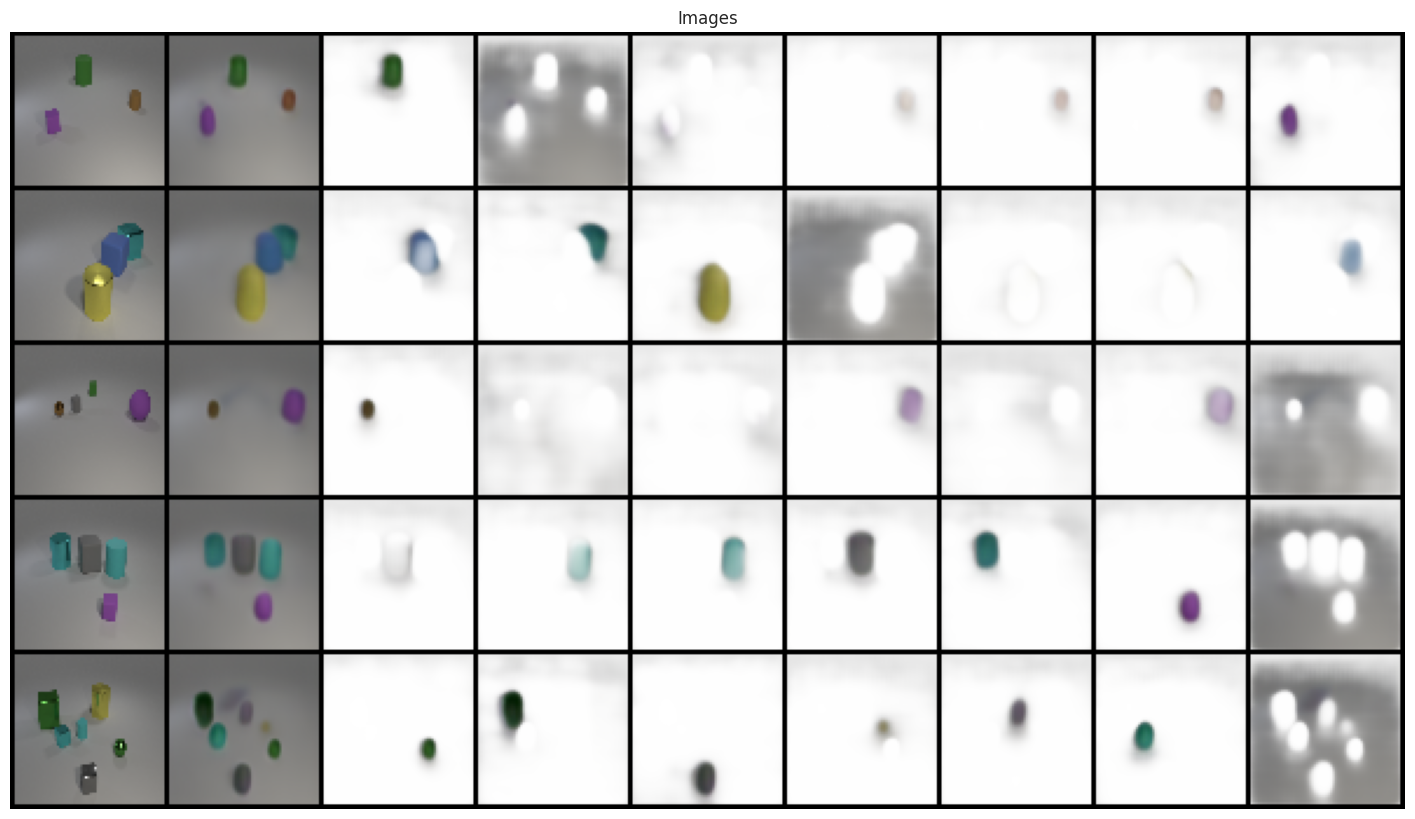

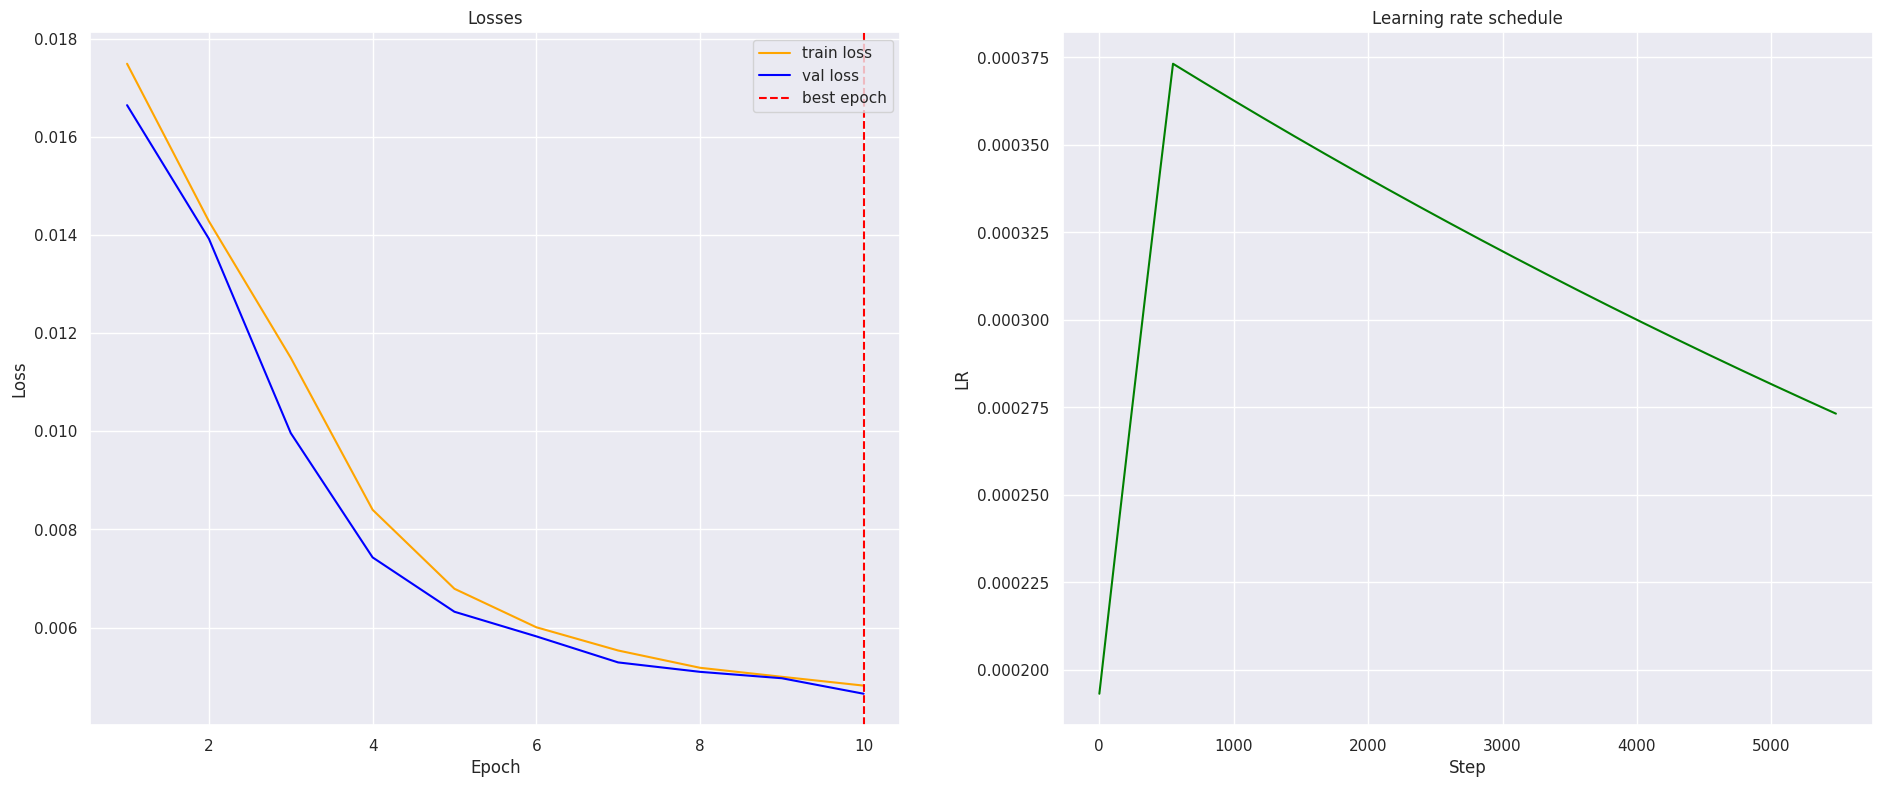

In [ ]:
seed_torch(seed)
epochs = 10
part2_tlosses, part2_vlosses, part2_lr_list, part2_time = train(model2, train_dataloader,
                                                 val_dataloader, epochs, optimizer,
                                                 scheduler, PART2_BM_WEIGHTS)
t2 = t2 + part2_time
times.append(t2)

In [ ]:
t2, times

(4944.380340576172, [4909.729380607605, 4944.380340576172])

In [ ]:
for i in range(len(part2_lr_list)):
    lr_list2.append(part2_lr_list[i])

if len(lr_list2) == len(part2_lr_list) + len(train_dataloader):
    print(len(lr_list2) == len(part2_lr_list) + len(train_dataloader))
    del part2_lr_list

len(lr_list2)

True


6028

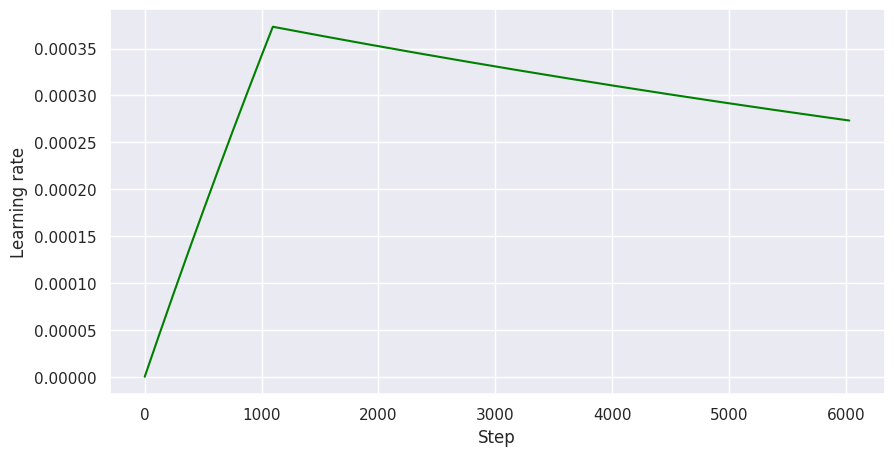

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs * len(train_dataloader) + len(train_dataloader) + 1), lr_list2, color = 'green')
plt.xlabel('Step')
plt.ylabel('Learning rate')
plt.show()

In [ ]:
for i in range(len(times)):
    times[i] = str(int(times[i] // 3600 % 24)) + ' h : ' + str(int(times[i] % 3600 // 60 // 10)) + str(int(times[i] % 3600 // 60 % 10)) + ' min : ' + str(int(times[i] % 60 // 10)) + str(int(times[i] % 60 % 10)) + ' sec'
print(times)

['1 h : 21 min : 49 sec', '1 h : 22 min : 24 sec']


In [ ]:
train_losses = []
val_losses = []
part1_tloss = min(part1_tlosses)
part2_tloss = min(part2_tlosses)
part1_vloss = min(part1_vlosses)
part2_vloss = min(part2_vlosses)
train_losses.append(f"{(part1_tloss):.4f}")
train_losses.append(f"{(part2_tloss):.4f}")
val_losses.append(f"{(part1_vloss):.4f}")
val_losses.append(f"{(part2_vloss):.4f}")
train_losses, val_losses

(['0.0043', '0.0048'], ['0.0041', '0.0047'])

In [ ]:
import pandas as pd
data = np.array([times[0], train_losses[0], val_losses[0], times[1], train_losses[1], val_losses[1]]).reshape(2, 3)

rows = ["Task #1. Slot Attention without trainable parameters μ, σ",
        "Task #2. Slot Attention with trainable parameters μ, σ"]
cols = ["training time", "train MSE loss", "val MSE loss"]
df = pd.DataFrame(data=data, index=rows, columns=cols)
df

,training time,train MSE loss,val MSE loss
"Task #1. Slot Attention without trainable parameters μ, σ",1 h : 21 min : 49 sec,0.0043,0.0041
"Task #2. Slot Attention with trainable parameters μ, σ",1 h : 22 min : 24 sec,0.0048,0.0047


#Выводы

Модель из второй части продемонстрировала результаты немного хуже, графики сходимости и затраченное на обучение время тоже не сильно отличаются. Т.е. в моей реализации с точки зрения показателей, по сути, ничего не поменялось, возможно стоило обучать дольше. Однако в первой модели обучаемые параметры, как я понял, отделены от всей модели, что не позволяет учиться на опыте модели, а это похоже на угадывание. Во второй части же мы вводим μ и σ в архитектуру модели и она полноценно обучается на выходе кодировщика и бэкпроп работает лучше.

**P.S. Понимаю, что нужно было бы построить графики ARI и Average Precision. Но похоже, что на Kaggle набор данных CLEVR неполон или имеет другую структуру для анализа. А на других сайтах этот набор данных аналогичен набору с Kaggle. Поэтому в задачах только MSE лосс для обучающей и валидационной выборок.**